## Likelihoods we have used:
1. regression: Gaussian
2. count regression: 
    Poisson: lambda=e^f,  Poisson2: lambda=ln(1+e^f)
3. binary classification: 
    Bernoulli: sigmoid,   Bernoulli2: Probit
    
For the sigmoid function, we use **expit** which is provided by *scipy.special*, because it is stable, fast and fairly accurate. Additionally, it is equivalent to sigmoid. For all methods, initial variational parameters are found by running the Laplace approximation on the subset/active set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv,norm,lstsq,cholesky
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
from sklearn import preprocessing
import random,time,GPy
from scipy.optimize import minimize
from scipy.special import loggamma,roots_hermitenorm,gamma,expit
from scipy.special import ndtr as std_norm_cdf

_sqrt_2pi = np.sqrt(2*np.pi)
_lim_val = np.finfo(np.float64).max
_lim_val_exp = np.log(_lim_val)

def std_norm_pdf(x): # define a standard normal pdf(from GPy)
    x = np.clip(x,-1e300,1e300)
    return np.exp(-np.square(x)/2)/_sqrt_2pi

def safe_exp(f):
    clip_f = np.clip(f, -np.inf, _lim_val_exp)
    return np.exp(clip_f)

def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

def kernel(X1, X2=None, l=1.0, sigma_f=1.0,K='SE'):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    if K=='diag': return sigma_f**2*np.ones((X1.shape[0], 1))
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T);sqdist=np.absolute(sqdist)#.ravel()))
    if K=='SE': return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist);
    elif K=='Matern32': return sigma_f**2 * (1+3**0.5*np.sqrt(sqdist)/l) * np.exp(-3**0.5*np.sqrt(sqdist)/l);
    elif K=='Matern52': return sigma_f**2 * (1+3**0.5*np.sqrt(sqdist)/l+5*sqdist/(3*l**2)) * np.exp(-5**0.5*np.sqrt(sqdist)/l);

def MFE(true_labels, pred_labels):
    '''
    Calculating mean fraction error(MFE) for count regression, the math is used as follows:
    MFE = mean( abs( (true_labels - pred_labels)./true_labels ) ) 
    Written by Kaikai
    '''    
    if true_labels.size != pred_labels.size:
        print('The size of true_labels and pred_labels is supposed to be identical.')
        return -1    
    true_labels = true_labels.flatten().astype('double'); pred_labels = pred_labels.flatten().astype('double')
    true_labels_temp = true_labels.copy()
    if 0 in true_labels: # replace zero with a very small positive value in order to avoid dividing by zero
        print('There are elements of zero value in true labels.')
        true_labels_temp[true_labels==0] = 1
    
    MFE = np.mean( np.abs( (true_labels - pred_labels)/true_labels_temp ) )
    return MFE

def calc_vlb(m,V, a, lik='Gaussian'):
    prior_mean_u = a[0]; prior_mean_f = a[1] # prior mean for inducing points    
    A = a[2] # Knm*inv(Kmm)
    Kmm = a[3]; Kmm_inv = a[4]; Kmn = a[5]; Knn_diag = a[6]; y = a[7] # the ground truth for training data
    noise_var = a[8]
    num_train = len(prior_mean_f);num_inducing = len(prior_mean_u)
    m_q = prior_mean_f + np.dot(A, (m-prior_mean_u)) # Eq.(3a) in paper
    v_q = ( Knn_diag.ravel() + np.diag(np.dot(A, np.dot(V-Kmm, A.T))) )[:, None] # Eq.(3b) in paper
#     v_q = np.absolute(v_q)
    c1 = m - prior_mean_u; c2 = np.dot(Kmm_inv, c1);#print(v_q[:20],min(v_q))
    (Sign,LogDetKmm) = np.linalg.slogdet(Kmm); LogDetKmm = Sign*LogDetKmm
    (SignV,LogDetV) = np.linalg.slogdet(V); LogDetV = SignV*LogDetV;#print(v_q[:50])     
    if lik=='Bernoulli':
        f,w = GH_quad(m_q,np.sqrt(v_q));#vlb_lik = expit(y*f);print('yf',expit(y*f))
        vlb_lik = np.sum( 1/_sqrt_2pi*np.dot( safe_ln(expit(y*f)) ,w) ) # sigmoid liklihood
#         vlb_lik = np.sum( 1.0/np.sqrt(2*np.pi)*np.dot( np.log(std_norm_cdf(y*f)+1e-10) ,w) ) # Probit liklihood
    elif lik=='Gaussian':
        vlb_lik = -np.log(np.sqrt(2*np.pi*noise_var)) - np.sum((y-m_q)**2+v_q)/(2*noise_var)
    elif lik=='Poisson':
        vlb_lik = np.dot(y.T,m_q) - np.sum(loggamma(y+1)) - np.sum(np.exp(m_q+0.5*v_q))
    elif lik=='Poisson2': # another link func: lambda=ln(1+e^f)
        f,w = GH_quad(m_q,np.sqrt(v_q));
        term1 = -np.sum(loggamma(y+1)); term2 = -np.sum( 1/_sqrt_2pi*np.dot( np.log(1+safe_exp(f)),w) )
        term3 = np.sum( 1/_sqrt_2pi*np.dot( y*safe_ln(np.log(1+safe_exp(f))),w) )
        vlb_lik = term1 + term2 + term3
    vlb_kl = 0.5*( LogDetKmm - LogDetV + np.dot(c1.T, c2) + np.trace(np.dot(Kmm_inv,V)) - len(prior_mean_u) )
    vlb = vlb_lik - vlb_kl
    return vlb 

def get_init_hyperparameters(Z,Z_label,lik='Poisson',K='SE'):
    # For all methods, initial variational parameters are found by running the Laplace approximation on the subset/active set.
    dim_data = Z.shape[1]
    if K=='SE': kern=GPy.kern.RBF(dim_data, variance=1.0, lengthscale=1.0);
    elif K=='Matern32': kern=GPy.kern.Matern32(dim_data, variance=1.0, lengthscale=1.0);
    elif K=='Matern52': kern=GPy.kern.Matern52(dim_data, variance=1.0, lengthscale=1.0);
    
    if lik=='Poisson': likelihood=GPy.likelihoods.Poisson();
    elif lik=='Poisson2': likelihood=GPy.likelihoods.Poisson(GPy.likelihoods.link_functions.Log_ex_1());
    elif lik=='Gaussian': likelihood=GPy.likelihoods.Gaussian();
    elif lik=='Bernoulli': likelihood=GPy.likelihoods.Bernoulli();

    laplace_inf = GPy.inference.latent_function_inference.Laplace()
    model_lap = GPy.core.GP(X=Z, Y=Z_label, likelihood=likelihood, inference_method=laplace_inf, kernel=kern)
    model_lap.optimize();
    if K=='SE': length_scale=model_lap.rbf.lengthscale[0];signal_variance=model_lap.rbf.variance[0]
    elif K=='Matern32': length_scale=model_lap.Mat32.lengthscale[0];signal_variance=model_lap.Mat32.variance[0]
    elif K=='Matern52': length_scale=model_lap.Mat52.lengthscale[0];signal_variance=model_lap.Mat52.variance[0]
    print(model_lap)
    return model_lap,length_scale,signal_variance

def Adam(theta, g_t, t, alpha=0.01, m_t=0, v_t=0, opt='minimize'):
    beta_1 = 0.9; beta_2 = 0.999; epsilon = 1e-8     #initialize the values of the parameters    
    m_t = beta_1*m_t + (1-beta_1)*g_t                #updates the moving averages of the gradient
    v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t)          #updates the moving averages of the squared gradient
    m_cap = m_t/(1-(beta_1**t))                      #calculates the bias-corrected estimates
    v_cap = v_t/(1-(beta_2**t))                      #calculates the bias-corrected estimates
    if opt=='maximize':
        theta = theta + (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)    #updates the parameters
    else:
        theta = theta - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)    #updates the parameters
    return theta, m_t, v_t

In [2]:
def GH_quad(mu_star,std_star): # gauss_hermite_quad to calculate numerical integration, w and z denote weights and sample points, respectively. 
    z,w = roots_hermitenorm(n=50, mu=False); z,w=z[:,None],w[:,None]
    z = np.kron(std_star,z.T) + mu_star
    return z,w

def calc_err(X, xStar, yTrue, l, sigma2, m, V,Kmm,Kmm_inv,noise_var=0.1,lik='Poisson',K='SE'):
    num_xStar = xStar.shape[0]; Kmn = kernel(X, xStar, l=l, sigma_f=np.sqrt(sigma2),K=K)
    Knn_diag = kernel(xStar, l=l, sigma_f=np.sqrt(sigma2),K='diag')+noise_var*np.eye(num_xStar)#np.eye(num_xStar)*sigma2+noise_var*np.eye(num_xStar)
    A = np.dot(Kmn.T, Kmm_inv);
    mu_star = np.dot(A,m); v2_star = Knn_diag + np.dot(A, np.dot(V-Kmm,A.T))
    std_star = np.sqrt(np.diag(v2_star))[:,None]
    if lik=='Bernoulli':
        p = calc_Bernoulli_pred(mu_star,std_star,yTrue); #res = np.where(p>=0.5,1,-1);print(min(p),max(p));
#         nll = -np.sum(safe_ln((1-0.5/p)*yTrue+0.5));
        nll = -np.sum(safe_ln(p))
        err = np.sum( np.where(p<0.5,1,0) )/num_xStar
#         err = np.sum( np.where(yTrue*res<0,1,0) )/num_xStar
        return err,nll
    elif lik=='Gaussian':
        mu, std = calc_Gauss_pred(mu_star,std_star,noise_var)
        err = np.sum( (yTrue-mu)**2 );
#         nll=0.5*np.dot(np.dot((yTrue-mu).T,np.diag(1/(std**2).ravel())),yTrue-mu)+np.sum(np.log(std))+num_xStar/2*np.log(2*np.pi)
        mse = 1/num_xStar*err;# print((yTrue-mu).shape);#print(std.shape);print(((yTrue-mu)/std).shape)        
#         nll = np.sum(np.log(std))+num_xStar/2*np.log(2*np.pi)+1/2*np.sum(((yTrue-mu)/std)**2)
        nll = 1/2*np.sum(((yTrue-mu)/std)**2)
#         nll=0.5*np.dot(np.dot((yTrue-mu).T,np.diag(1/(std**2).ravel())),yTrue-mu)+0.5*np.log(np.diag((std**2).ravel())+num_xStar/2*np.log(2*np.pi)
        return mse,nll
    else: # Poisson, Poisson2
        y_min = min(yTrue); y_max = max(yTrue); #print(y_min,y_max)
        pmf = calc_Poisson_pred(mu_star,std_star,num_xStar,y_min,y_max,lik);#print(pmf.shape);#print(pmf[:3,:]);#print((yTrue-y_min).astype(int).shape)
        nll = -np.sum(safe_ln(pmf[np.arange(len(pmf)),(yTrue-y_min).astype(int).ravel()]));#print(pmf[np.arange(len(pmf)),(yTrue-y_min).astype(int).ravel()])
        res = np.argmax(pmf, axis=1)+y_min; err = MFE(yTrue, res)
        return err,nll

def calc_Gauss_pred(mu_star,std_star,noise_var):
    return mu_star, std_star+np.sqrt(noise_var)

def calc_Poisson_pred(mu_star,std_star,num_xStar,y_min,y_max,lik='Poisson'):
    f,w = GH_quad(mu_star,std_star)
    y_range = np.arange(y_min,y_max+1)
    lik_func = {
        'Poisson': lambda f,y: 1/gamma(y+1)*safe_exp(-safe_exp(f)+f*y),
        'Poisson2': lambda f,y: 1/gamma(y+1)*expit(-f)*( safe_ln(1.0+safe_exp(f))**y )
    }[lik]
    poisson_lik = np.zeros((num_xStar,len(y_range)))
    for i,y in enumerate(y_range):
        poisson_lik[:,i] = 1/_sqrt_2pi*np.dot(lik_func(f,y),w).ravel()
    return poisson_lik

def calc_Bernoulli_pred(mu_star,std_star,y):
#     v = std_star**2; kappa_v = (1+np.pi*v/8.0)**(-1/2) # Probit liklihood
#     p = sigmoid(kappa_v*mu_star) # p(y=1|x_*,m,V)
    f,w = GH_quad(mu_star,std_star) # sigmoid liklihood
    p = 1/np.sqrt(2*np.pi)*np.dot( expit(f*y), w ) # p(y=1|x_*,m,V)
    return p

def calc_m_q(m, A, prior_u, prior_f):
#     print(A.shape);print(m.shape)
    return prior_f + np.dot(A, (m-prior_u))

def calc_v_q(V, A, Kmm, Knn_diag):
    return ( Knn_diag.ravel() + np.diag(np.dot(A, np.dot(V-Kmm, A.T))) )[:,None] # Eq.(3b) in paper

def calc_rho(m_q, v_q, y, lik='Poisson', noise_var=0.1):
    if lik=='Bernoulli':
        f,w = GH_quad(m_q,np.sqrt(v_q))
        return 1.0/_sqrt_2pi*np.dot(  y*expit(-y*f) , w ) # sigmoid liklihood
#         return 1.0/_sqrt_2pi*np.dot( y*std_norm_pdf(f) / (std_norm_cdf(y*f)+1e-10), w ) # Probit liklihood        
    elif lik=='Gaussian':
        return 1.0/noise_var*(y-m_q)
    elif lik=='Poisson':
        return -np.exp(m_q + 0.5*v_q) + y
    elif lik=='Poisson2':
        f,w = GH_quad(m_q,np.sqrt(v_q))
        y = np.tile(y,[1,f.shape[1]]); term2 = expit(f); t0 = safe_ln(1+safe_exp(f))# avoid dividing by zeros
        d1_log_lik = np.zeros(t0.shape)
        d1_log_lik[t0!=0] = (y[t0!=0]/t0[t0!=0] - 1)*term2[t0!=0]
        return 1.0/_sqrt_2pi*np.dot(  d1_log_lik, w )
    
def calc_lambda(m_q, v_q, y, lik='Poisson', noise_var=0.1):
    if lik=='Bernoulli':
        f,w = GH_quad(m_q,np.sqrt(v_q))
        return 1.0/np.sqrt(2*np.pi)*np.dot(  -expit(y*f)*expit(-y*f), w ) # sigmoid
#         return 1.0/_sqrt_2pi*np.dot( -std_norm_pdf(f)**2 / (std_norm_cdf(y*f)**2+1e-10) - y*f*std_norm_pdf(f) / (std_norm_cdf(y*f)+1e-10), w )
    elif lik=='Gaussian':
        return -1.0/noise_var*np.ones((len(m_q),1))
    elif lik=='Poisson':
        return -np.exp(m_q + 0.5*v_q)
    elif lik=='Poisson2':
        f,w = GH_quad(m_q,np.sqrt(v_q));y = np.tile(y,[1,f.shape[1]]);
        term2 = expit(f)*expit(f); t0 = safe_ln(1+safe_exp(f));d2_log_lik = np.zeros(t0.shape)
        d2_log_lik[t0!=0] = ((y[t0!=0]/t0[t0!=0]-1)*safe_exp(-f[t0!=0])-y[t0!=0]/(t0[t0!=0])**2)*term2[t0!=0]
        return 1.0/_sqrt_2pi*np.dot(  d2_log_lik, w )

def dVLb_dm(m, rho, prior_mean_u, Kmm_inv, A,batch_size=None,num_train=None):
    if batch_size is None: coef=1
    else: coef=num_train/batch_size
    dm = np.dot(A.T,rho)*coef - np.dot(Kmm_inv, m-prior_mean_u) # Eq.(11a) in paper
    return dm

def dVLb_dL(L, lam, Kmm_inv, A, noise_var=1e-8,batch_size=None,num_train=None):# optimizing the cholesky factor L guarantees the PSD of V automatically
    if batch_size is None: coef=1
    else: coef=num_train/batch_size
    dL = np.dot( np.dot( np.dot(A.T, np.diag(lam.ravel())), A ), L )*coef + inv(L+np.sqrt(noise_var)*np.eye(len(L))).T - np.dot(Kmm_inv, L)
    return dL

def SDSVI(X,Y,Kmm,Kmm_inv,Kmn,Knn_diag,m,L,V,prior_u,prior_f,noise_var,var,num_inducing,num_iter,lr,m_t,v_t,lik,batch_size=500):
    num_train=X.shape[0];
    indx = random.sample(range(num_train),batch_size);
    Xb = X[indx, :]; Yb_label = Y[indx];prior_f=prior_f[indx]
    rows=np.arange(num_inducing); cols=np.asarray(indx, dtype=np.intp)
    Kmn_sto=Kmn[np.ix_(rows, cols)]; A = np.dot(Kmn_sto.T, Kmm_inv);
    Knn_diag=Knn_diag[cols];
    m_q = calc_m_q(m, A, prior_u, prior_f); v_q = calc_v_q(V, A, Kmm, Knn_diag);
    rho = calc_rho(m_q, v_q,Yb_label,lik, noise_var); lam = calc_lambda(m_q, v_q,Yb_label,lik, noise_var)
#     rho = rho[cols]; lam = lam[cols];
    var = np.hstack([m.flatten(), L.flatten()])
    dm = dVLb_dm(m, rho, prior_u, Kmm_inv, A,batch_size,num_train)
    dL = dVLb_dL(L, lam, Kmm_inv, A, noise_var,batch_size,num_train)
    gradients = np.hstack([dm.flatten(), dL.flatten()])
    var, m_t, v_t = Adam(var,gradients,num_iter,lr,m_t,v_t,opt='maximize')
    m = var[:num_inducing][:,None] # variantional mean
    L = var[num_inducing:].reshape(num_inducing,num_inducing) # variational variance V=L*L.T
    V = np.dot(L, L.T)
    return m,L,V,m_t,v_t

def SDSVI1(X,Y,Z,ls,sf2,K,Kmm,Kmm_inv,m,L,V,prior_u,prior_f,noise_var,num_inducing,num_iter,lr,m_t,v_t,lik,batch_size=500):
    num_train=X.shape[0];    
    indx = random.sample(range(num_train),batch_size);
    Xb = X[indx, :]; Yb_label = Y[indx];prior_f=prior_f[indx]
    Kmn=kernel(Z, Xb, l = ls, sigma_f = np.sqrt(sf2),K=K);
    Knn_diag =kernel(Xb, l = ls, sigma_f = np.sqrt(sf2),K='diag');
    A = np.dot(Kmn.T, Kmm_inv) # Knm*inv(Kmm)
    m_q = calc_m_q(m, A, prior_u, prior_f); v_q = calc_v_q(V, A, Kmm, Knn_diag);
    rho = calc_rho(m_q, v_q, Yb_label,lik, noise_var); lam = calc_lambda(m_q, v_q,Yb_label,lik, noise_var);
    dm = dVLb_dm(m, rho, prior_u, Kmm_inv, A,batch_size,num_train)
    dL = dVLb_dL(L, lam, Kmm_inv, A, noise_var,batch_size,num_train)
    gradients = np.hstack([dm.flatten(), dL.flatten()]);var = np.hstack([m.flatten(), L.flatten()])
    var, m_t, v_t = Adam(var,gradients,num_iter,lr,m_t, v_t,opt='maximize')
    m = var[:num_inducing][:,None] # variantional mean
    L = var[num_inducing:].reshape(num_inducing,num_inducing) # variational variance V=L*L.T
    V = np.dot(L, L.T)
    return m,L,V,m_t,v_t

def MCSSVI(X,Y,Kmm,Kmm_inv,Kmn,Knn_diag,m,V,prior_u,prior_f,noise_var,var,num_inducing,num_iter,lik,batch_size=500):
    num_train=X.shape[0];
    indx = random.sample(range(num_train),batch_size);
    Xb = X[indx, :]; Yb_label = Y[indx];prior_f=prior_f[indx]
    rows=np.arange(num_inducing); cols=np.asarray(indx, dtype=np.intp)
    Kmn_sto=Kmn[np.ix_(rows, cols)]; A = np.dot(Kmn_sto.T, Kmm_inv);
    Knn_diag=Knn_diag[cols];
    m_q = calc_m_q(m, A, prior_u, prior_f); v_q = calc_v_q(V, A, Kmm, Knn_diag);
    rho = calc_rho(m_q, v_q,Yb_label,lik, noise_var); lam = calc_lambda(m_q, v_q,Yb_label,lik, noise_var)
    d = A.T; gamma = -lam; #print('old m:',m[:1]); print('old V:',V[:2,:2])
    step_size = num_iter**(-1);#V_old=V
    interm_V = Kmm_inv+ num_train/batch_size * np.dot( np.dot(A.T, np.diag(gamma.ravel())), A) #intermediate parameter
    V = inv( (1-step_size)*V + step_size*interm_V )
    interm_m = num_train/batch_size * np.dot(d, rho + np.dot(A,m)*gamma)
    m = (1-step_size)*m + step_size*np.dot(V, interm_m ) # assume prior_u=0
#     m = (1-step_size)*np.dot(V,np.dot(inv(V_old),m)) + step_size*np.dot(V, interm_m ) # assume prior_u=0
#     m = np.dot(V, num_train/batch_size * np.dot(d, rho + np.dot(A,m)*gamma) );
    return m,V

def HMCSSVI(X,Y,Kmm,Kmm_inv,Kmn,Knn_diag,m,V,prior_u,prior_f,noise_var,var,num_inducing,num_iter,lr,m_t,v_t,lik,batch_size=500):
    num_train=X.shape[0];
    indx = random.sample(range(num_train),batch_size);
    Xb = X[indx, :]; Yb_label = Y[indx];prior_f=prior_f[indx]
    rows=np.arange(num_inducing); cols=np.asarray(indx, dtype=np.intp)
    Kmn_sto=Kmn[np.ix_(rows, cols)]; A = np.dot(Kmn_sto.T, Kmm_inv); Knn_diag=Knn_diag[cols];
    m_q = calc_m_q(m, A, prior_u, prior_f); v_q = calc_v_q(V, A, Kmm, Knn_diag);
    rho = calc_rho(m_q, v_q,Yb_label,lik, noise_var); lam = calc_lambda(m_q, v_q,Yb_label,lik, noise_var)
    d = A.T; gamma = -lam; #print('old m:',m[:1]); print('old V:',V[:2,:2])
    step_size = num_iter**(-1);#V_old=V
    interm_V = Kmm_inv+ num_train/batch_size * np.dot( np.dot(A.T, np.diag(gamma.ravel())), A) #intermediate parameter
    V = inv( (1-step_size)*V + step_size*interm_V )
    dm = dVLb_dm(m, rho, prior_u, Kmm_inv, A,batch_size,num_train)
    m, m_t, v_t = Adam(m,dm,num_iter,lr,m_t, v_t,opt='maximize')
#     m = (1-step_size)*np.dot(V,np.dot(inv(V_old),m)) + step_size*np.dot(V, interm_m ) # assume prior_u=0
#     m = np.dot(V, num_train/batch_size * np.dot(d, rho + np.dot(A,m)*gamma) );
    return m,V,m_t,v_t

In [3]:
def Train(X,Y,ix,X_test=None,y_test=None,max_iter=100,lr=1*10**-5,FPb_cond=1*10**0,stop_cond=1*10**-5,VLB_opt='GD',lik='Poisson',K='SE'):
    num_train = X.shape[0];num_inducing=len(ix);num_test=X_test.shape[0]; 
    prior_u = np.zeros((num_inducing, 1)); prior_f = np.zeros((num_train, 1))
    Z = X[ix, :]; Z_label = Y[ix] # Z is the inducing set
    model_lap,ls,sf2 = get_init_hyperparameters(Z,Z_label,lik=lik,K=K)#(Z_label+1)/2    
    # variational parameters from initialization
    f_mean, f_var = model_lap._raw_predict(X) ; #print(ls,sf2)
#     ls = model_lap.rbf.lengthscale[0]; sf2 = model_lap.rbf.variance[0]; # length_scale,sigma_f2
    if lik=='Gaussian': noise_var=model_lap.Gaussian_noise.variance[0] 
    else: noise_var=1*10**-8
    #  we use variational mean from Laplace appr
    m = f_mean[ix]; V = np.diag(f_var[ix].ravel()); L = cholesky(V);#print(min(f_var))
    Kmm = kernel(Z, Z, l = ls, sigma_f = np.sqrt(sf2),K=K) + noise_var*np.eye(len(Z))
    Kmm_inv = inv(Kmm); Kmn = kernel(Z, X, l = ls, sigma_f = np.sqrt(sf2),K=K); 
    Knn_diag =kernel(X, l = ls, sigma_f = np.sqrt(sf2),K='diag'); #sf2*np.ones((num_train, 1))
    A = np.dot(Kmn.T, Kmm_inv) # Knm*inv(Kmm)    
    a = (prior_u,prior_f,A,Kmm,Kmm_inv,Kmn,Knn_diag,Y,noise_var)
    num_iter = 0; VLB = []; VLB_time = []; err = []; nll=[]; FPb_converge = False# True
    var = np.hstack([m.flatten(), L.flatten()])
    start_time = time.time(); VLB.append(-calc_vlb(m,V, a,lik)[0][0]);
    res = calc_err(Z,X_test,y_test,ls,sf2,m,V,Kmm,Kmm_inv,noise_var=noise_var,lik=lik,K=K)
    err.append(res[0]); nll.append(res[1]);
    VLB_time.append(time.time()-start_time);print('Before iterations, VLB:{:.6f} err:{:.6f}, nll:{:.6f}'.format(VLB[-1],err[-1],nll[-1]) )
    m_t=0; v_t=0;batch_size=10
    while 1:
        num_iter = num_iter +1;#break
        if VLB_opt in ['GD','FPi','FPb','FPi-mean']:
            m_q = calc_m_q(m, A, prior_u, prior_f); v_q = calc_v_q(V, A, Kmm, Knn_diag);#print('m_q:',m_q[:10])
            # According to Table 1 in paper, expectations of the derivatives wrt N(f|m,v) for Possion likelihood
            rho = calc_rho(m_q, v_q, Y,lik, noise_var); lam = calc_lambda(m_q, v_q,Y,lik, noise_var);
        if VLB_opt=='SDSVI1':
            m,L,V,m_t,v_t = SDSVI1(X,Y,Z,ls,sf2,K,Kmm_inv,m,L,V,prior_u,prior_f,noise_var,num_inducing,num_iter,lr,m_t,v_t,lik,batch_size)
            
        if VLB_opt=='SDSVI':
            m,L,V,m_t,v_t=SDSVI(X,Y,Kmm,Kmm_inv,Kmn,Knn_diag,m,L,V,prior_u,prior_f,noise_var,var,num_inducing,num_iter,lr,m_t,v_t,lik,batch_size)
            
        if VLB_opt=='MCSSVI':
            m,V=MCSSVI(X,Y,Kmm,Kmm_inv,Kmn,Knn_diag,m,V,prior_u,prior_f,noise_var,var,num_inducing,num_iter,lik,batch_size)
        if VLB_opt=='HMCSSVI':
            m,V,m_t,v_t=HMCSSVI(X,Y,Kmm,Kmm_inv,Kmn,Knn_diag,m,V,prior_u,prior_f,noise_var,var,num_inducing,num_iter,lr,m_t,v_t,lik,batch_size)
        
        if VLB_opt=='GD':
            dm = dVLb_dm(m, rho, prior_u, Kmm_inv, A); dL = dVLb_dL(L, lam, Kmm_inv, A, noise_var)
            gradients = np.hstack([dm.flatten(), dL.flatten()])
            var, m_t, v_t = Adam(var,gradients,num_iter,lr,m_t, v_t,opt='maximize')
            m = var[:num_inducing][:,None] # variantional mean
            L = var[num_inducing:].reshape(num_inducing,num_inducing) # variational variance V=L*L.T
            V = np.dot(L, L.T);
            
        elif VLB_opt=='FPi':
            dm = dVLb_dm(m, rho, prior_u, Kmm_inv, A)
            m, m_t, v_t = Adam(m,dm,num_iter,lr,m_t, v_t,opt='maximize') # print('old V',V[:1,:1])
            V = inv(Kmm_inv-np.dot( np.dot(A.T, np.diag(lam.ravel())), A ));
        elif VLB_opt=='FPb':            
            if FPb_converge:
                dm = dVLb_dm(m, rho, prior_u, Kmm_inv, A); #print('old m:',m[:1]);
                m, m_t, v_t = Adam(m,dm,num_iter,lr,m_t, v_t,opt='maximize')
            else:
                V = inv(Kmm_inv-np.dot( np.dot(A.T, np.diag(lam.ravel())), A))
                
        elif VLB_opt=='FPi-mean':
            d = A.T; gamma = -lam; #print('old m:',m[:1]); print('old V:',V[:2,:2])
            V = inv(Kmm_inv+np.dot( np.dot(A.T, np.diag(gamma.ravel())), A))
#             V = inv(Kmm_inv-np.dot( np.dot(A.T, np.diag(lam.ravel())), A))
            m = np.dot(V, np.dot(d, rho + np.dot(A,m)*gamma) );

        VLB.append(-calc_vlb(m,V, a,lik)[0][0]); VLB_time.append(time.time()-start_time)
        res = calc_err(Z,X_test,y_test,ls,sf2,m,V,Kmm,Kmm_inv,noise_var=noise_var,lik=lik,K=K)
        err.append(res[0]); nll.append(res[1])
        if num_iter>0:
            delta_vlb = abs(VLB[-1]-VLB[-2])
            if num_iter%1 == 0:
                print('iter:{}, delta_VLB:{:.6f}, negVLB:{:.6f}, err:{:.6f}, nll:{:.6f}'.format(num_iter, VLB[-2]-VLB[-1], VLB[-1], err[-1],nll[-1]));
            if VLB_opt=='FPb' and delta_vlb<=FPb_cond:
                FPb_converge = not FPb_converge; #print('m or V converged')
            if num_iter>5 and delta_vlb<=stop_cond:
                if np.average(VLB[-2:])<np.average(VLB[-4:]):
                    if num_iter>=max_iter: print('It has reached the maximum number of iterations.');break
                    else:continue
                else: print('After {} iterations it converged: delta_VLB:{:.6f}, negVLB:{:.6f}, err:{:.6f}'.format(num_iter,delta_vlb,VLB[-1],err[-1]) );break                
            if num_iter>22 and np.average(VLB[-6:])>=np.average(VLB[-12:]): print('negVLB did not decrease any more.'); break;            
            elif num_iter==max_iter:
                print('It has reached the maximum number of iterations, i.e. {}, with delta_VLB:{:.6f}, negVLB:{:.6f} and err:{:.6f}'.format(max_iter,delta_vlb,VLB[-1],err[-1]));break            
    return Z,Z_label, VLB, ls, sf2, m, V,noise_var, Kmm, Kmm_inv, A,VLB_time,err,nll

In [5]:
k='Matern52';lik='Poisson2';lr=1*10**0#0.5*10**-2;HMCSSVI
# FPimSDm = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='MCSSVI',lik=lik,K=k)#Gaussian,Bernoulli,Poisson2,SDSVI
# Zs,Zs_label, VLBSDm, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_timeSDm,errSDm,nllSDm=FPimSDm#Matern52,SE,Matern32
FPimSD = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='SDSVI',lik=lik,K=k)#Gaussian,Bernoulli,Poisson2,SDSVI
Zs,Zs_label, VLBSD, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_timeSD,errSD,nllSD=FPimSD#Matern52,SE,Matern32
FPim1 = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='GD',lik=lik,K=k)#Gaussian,Bernoulli,Poisson2,SDSVI
Zs,Zs_label, VLB1, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time1,err1,nll1=FPim1#Matern52,SE,Matern32
# FPim2 = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='FPb',lik=lik,K=k)#Gaussian,Bernoulli
# Zs,Zs_label, VLB2, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time2,err2,nll2=FPim2#Matern52,SE
# FPim3 = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='FPi',lik=lik,K=k)#Gaussian,Bernoulli
# Zs,Zs_label, VLB3, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time3,err3,nll3=FPim3#Matern32,SE
# FPim4 = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='FPi-mean',lik=lik,K=k)#Gaussian,Bernoulli
# Zs,Zs_label, VLB4, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time4,err4,nll4=FPim4#Matern32,SE
# FPH = Train(X_train,y_train,ix,X_test,y_test,max_iter=300,lr=lr,VLB_opt='HMCSSVI',lik=lik,K=k)#Gaussian,Bernoulli,Poisson2,SDSVI
# Zs,Zs_label, VLBH, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_timeH,errH,nllH=FPH#Matern52,SE,Matern32


Name : gp
Objective : 459.10391982352337
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                |              value  |  constraints  |  priors
  Mat52.variance     |  297.5487109425978  |      +ve      |        
  Mat52.lengthscale  |  68.51895321692969  |      +ve      |        
Before iterations, VLB:8083.693181 err:0.095661, nll:1911.969069
iter:1, delta_VLB:-43755.271759, negVLB:51838.964940, err:0.173005, nll:2620.969336
iter:2, delta_VLB:6611.120946, negVLB:45227.843994, err:0.132962, nll:2586.262705
iter:3, delta_VLB:-13884.544631, negVLB:59112.388625, err:0.191476, nll:2694.512141
iter:4, delta_VLB:-10867.237586, negVLB:69979.626211, err:0.222624, nll:2770.462708
iter:5, delta_VLB:-11196.451581, negVLB:81176.077792, err:0.273114, nll:2849.495826
iter:6, delta_VLB:-8527.988292, negVLB:89704.066084, err:0.289623, nll:2892.207009
iter:7, delta_VLB:-3363.983357, negVLB:93068.049441, err:0.298807, nll:2910.653784
iter:8, delt

iter:96, delta_VLB:589.399182, negVLB:23390.379576, err:0.577993, nll:2816.515277
iter:97, delta_VLB:499.632375, negVLB:22890.747201, err:0.570793, nll:2801.253845
iter:98, delta_VLB:302.112879, negVLB:22588.634322, err:0.568625, nll:2791.852343
iter:99, delta_VLB:9.627362, negVLB:22579.006960, err:0.562644, nll:2785.166537
iter:100, delta_VLB:-208.124399, negVLB:22787.131359, err:0.556602, nll:2777.173382
iter:101, delta_VLB:-153.426274, negVLB:22940.557633, err:0.550980, nll:2768.603121
iter:102, delta_VLB:-231.584188, negVLB:23172.141820, err:0.542828, nll:2757.987741
iter:103, delta_VLB:-156.024315, negVLB:23328.166135, err:0.534689, nll:2744.790113
iter:104, delta_VLB:-223.568037, negVLB:23551.734172, err:0.526799, nll:2731.043856
iter:105, delta_VLB:-29.427770, negVLB:23581.161942, err:0.519334, nll:2715.419063
iter:106, delta_VLB:267.631020, negVLB:23313.530922, err:0.517709, nll:2698.765056
negVLB did not decrease any more.

Name : gp
Objective : 459.10391982352337
Number of Pa

iter:86, delta_VLB:0.467833, negVLB:7906.879226, err:0.066177, nll:1903.516518
iter:87, delta_VLB:0.390212, negVLB:7906.489013, err:0.066862, nll:1903.631981
iter:88, delta_VLB:0.297618, negVLB:7906.191395, err:0.066669, nll:1903.755592
iter:89, delta_VLB:0.211458, negVLB:7905.979937, err:0.066466, nll:1903.881206
iter:90, delta_VLB:0.166361, negVLB:7905.813575, err:0.066623, nll:1904.003330
iter:91, delta_VLB:0.134862, negVLB:7905.678714, err:0.066156, nll:1904.116694
iter:92, delta_VLB:0.112795, negVLB:7905.565918, err:0.066324, nll:1904.213661
iter:93, delta_VLB:0.112350, negVLB:7905.453568, err:0.065885, nll:1904.285710
iter:94, delta_VLB:0.113677, negVLB:7905.339891, err:0.065483, nll:1904.328876
iter:95, delta_VLB:0.107278, negVLB:7905.232612, err:0.065106, nll:1904.344928
iter:96, delta_VLB:0.108595, negVLB:7905.124018, err:0.064503, nll:1904.338353
iter:97, delta_VLB:0.118589, negVLB:7905.005429, err:0.064364, nll:1904.314111
iter:98, delta_VLB:0.118749, negVLB:7904.886679, err

iter:189, delta_VLB:0.000012, negVLB:7903.915823, err:0.064693, nll:1903.885873
iter:190, delta_VLB:0.000010, negVLB:7903.915813, err:0.064693, nll:1903.885223
iter:191, delta_VLB:0.000007, negVLB:7903.915806, err:0.064693, nll:1903.884737
iter:192, delta_VLB:0.000005, negVLB:7903.915801, err:0.064693, nll:1903.884412
iter:193, delta_VLB:0.000003, negVLB:7903.915798, err:0.064693, nll:1903.884238
iter:194, delta_VLB:0.000002, negVLB:7903.915796, err:0.064693, nll:1903.884254
iter:195, delta_VLB:0.000002, negVLB:7903.915793, err:0.064693, nll:1903.884477
iter:196, delta_VLB:0.000003, negVLB:7903.915790, err:0.064693, nll:1903.884852
iter:197, delta_VLB:0.000003, negVLB:7903.915787, err:0.064693, nll:1903.885311
iter:198, delta_VLB:0.000004, negVLB:7903.915783, err:0.064693, nll:1903.885827
iter:199, delta_VLB:0.000004, negVLB:7903.915780, err:0.064850, nll:1903.886364
iter:200, delta_VLB:0.000003, negVLB:7903.915777, err:0.064850, nll:1903.886843
iter:201, delta_VLB:0.000003, negVLB:790

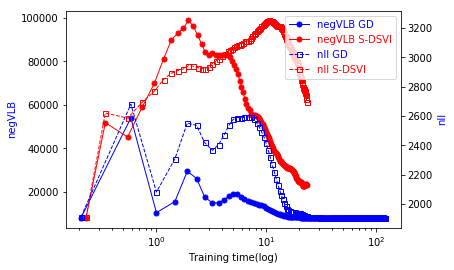

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("negVLB");
# par.set_ylabel("err")
# p0, = host.plot(VLB_time1, VLB1, 'bo-', lw=1, markersize=5, label="negVLB GD")
# p1, = host.plot(VLB_timeSD, VLBSD, 'ro-', lw=1, markersize=5, label="negVLB S-DSVI")
# p2, = par.plot(VLB_time1, err1, 'bs--', lw=1, markersize=5,fillstyle='none', label="err GD")
# p3, = par.plot(VLB_timeSD, errSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="err S-DSVI")
par.set_ylabel("nll")
p0, = host.plot(VLB_time1, VLB1, 'bo-', lw=1, markersize=5, label="negVLB GD")
p1, = host.plot(VLB_timeSD, VLBSD, 'ro-', lw=1, markersize=5, label="negVLB S-DSVI")
p2, = par.plot(VLB_time1, nll1, 'bs--', lw=1, markersize=5,fillstyle='none', label="nll GD")
p3, = par.plot(VLB_timeSD, nllSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="nll S-DSVI")
# p2, = par.plot(VLB_time1, nll1, 'bs--', lw=1, markersize=5,fillstyle='none', label="nll GD")
# p3, = par.plot(VLB_timeSD, nllSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="nll S-DSVI")
# p2, = par.plot(VLB_time1, err1, 'bs--', lw=1, markersize=5,fillstyle='none', label="err GD")
# p3, = par.plot(VLB_timeSD, errSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="err S-DSVI")
# p5, = par.plot(VLB_timeSD1, nllSD1, 'gs--', lw=1, markersize=5,fillstyle='none', label="nll SDSVI1")

host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());par.yaxis.get_label().set_color(p2.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
leg.texts[3].set_color(p3.get_color())
# leg.texts[4].set_color(p4.get_color());
# leg.texts[5].set_color(p5.get_color())
plt.show()

In [124]:
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("nll");
p0, = host.plot(VLB_timeSD, nllSD, 'bo-', lw=1, markersize=5, label="S-DSVI")
p1, = host.plot(VLB_timeH, nllH, 'go-', lw=1, markersize=5, label="H-MC-SSVI")
p2, = host.plot(VLB_timeSDm, nllSDm, 'ro-', lw=1, markersize=5, label="MC-SSVI")
# host.set_ylabel("err")
# p0, = host.plot(VLB_timeSD, errSD, 'bo-', lw=1, markersize=5, label="S-DSVI")
# p1, = host.plot(VLB_timeH, errH, 'go-', lw=1, markersize=5, label="H-MC-SSVI")
# p2, = host.plot(VLB_timeSDm, errSDm, 'ro-', lw=1, markersize=5, label="MC-SSVI")
# p2, = par.plot(VLB_time1, nll1, 'bs--', lw=1, markersize=5,fillstyle='none', label="nll GD")
# p3, = par.plot(VLB_timeSD, nllSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="nll SD-SVI")
# p2, = par.plot(VLB_time1, err1, 'bs--', lw=1, markersize=5,fillstyle='none', label="err GD")
# p3, = par.plot(VLB_timeSD, errSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="nll SD-SVI")
# p5, = par.plot(VLB_timeSD1, nllSD1, 'gs--', lw=1, markersize=5,fillstyle='none', label="nll SDSVI1")

host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());#par.yaxis.get_label().set_color(p2.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
# leg.texts[3].set_color(p3.get_color())
# leg.texts[4].set_color(p4.get_color());
# leg.texts[5].set_color(p5.get_color())
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("negVLB");
# par.set_ylabel("ERR")
par.set_ylabel("NLL")

p0, = host.plot(VLB_time1, VLB1, 'bo-', lw=1, markersize=5, label="negVLB GD")
p1, = host.plot(VLB_timeSD, VLBSD, 'ro-', lw=1, markersize=5, label="negVLB SDSVI")
# p2, = host.plot(VLB_timeSD1, VLBSD1, 'go-', lw=1, markersize=5, label="negVLB SDSVI1")
p2, = par.plot(VLB_time1, nll1, 'bs--', lw=1, markersize=5,fillstyle='none', label="nll GD")
p3, = par.plot(VLB_timeSD, nllSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="nll SDSVI")
# p2, = par.plot(VLB_time1, err1, 'bs--', lw=1, markersize=5,fillstyle='none', label="nll GD")
# p3, = par.plot(VLB_timeSD, errSD, 'rs--', lw=1, markersize=5,fillstyle='none', label="nll SDSVI")
# p5, = par.plot(VLB_timeSD1, nllSD1, 'gs--', lw=1, markersize=5,fillstyle='none', label="nll SDSVI1")

host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());par.yaxis.get_label().set_color(p2.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
leg.texts[3].set_color(p3.get_color())
# leg.texts[4].set_color(p4.get_color());
# leg.texts[5].set_color(p5.get_color())
plt.show()

In [1020]:
VLB1 = (VLB1-min(VLB1))/(max(VLB1)-min(VLB1)); nll1 = (nll1-min(nll1))/(max(nll1)-min(nll1))
VLB2 = (VLB2-min(VLB2))/(max(VLB2)-min(VLB2)); nll2 = (nll2-min(nll2))/(max(nll2)-min(nll2))
VLB3 = (VLB3-min(VLB3))/(max(VLB3)-min(VLB3)); nll3 = (nll3-min(nll3))/(max(nll3)-min(nll3))
VLB4 = (VLB4-min(VLB4))/(max(VLB4)-min(VLB4)); nll4 = (nll4-min(nll4))/(max(nll4)-min(nll4))

In [14]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [43]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
# par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("negVLB")

p0, = host.plot(VLB_time1, VLB1, 'bo-', lw=1, markersize=5, label="negVLB GD")
p1, = host.plot(VLB_time2, VLB2, 'ro-', lw=1, markersize=5, label="negVLB FPb")
p2, = host.plot(VLB_time3, VLB3, 'go-', lw=1, markersize=5, label="negVLB FPi")
p3, = host.plot(VLB_time4, VLB4, 'co-', lw=1, markersize=5, label="negVLB FPi-mean")

host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());#par.yaxis.get_label().set_color(p0.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
leg.texts[3].set_color(p3.get_color())
plt.show()

In [44]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("Error")
par.set_ylabel("NLL")#negVLB
p0, = host.plot(VLB_time1, err1, 'bo--', lw=1, markersize=5, fillstyle='none', label="error GD")
p1, = host.plot(VLB_time2, err2, 'ro--', lw=1, markersize=5, fillstyle='none', label="error FPb")
p2, = host.plot(VLB_time3, err3, 'go--', lw=1, markersize=5, fillstyle='none', label="error FPi")
p3, = host.plot(VLB_time4, err4, 'co--', markersize=5, lw=1, fillstyle='none', label="error FPi-mean")
p4, = par.plot(VLB_time1, nll1, 'bs-', lw=1, markersize=5, label="nll GD")
p5, = par.plot(VLB_time2, nll2, 'rs-', lw=1, markersize=5, label="nll FPb")
p6, = par.plot(VLB_time3, nll3, 'gs-', lw=1, markersize=5, label="nll FPi")
p7, = par.plot(VLB_time4, nll4, 'cs-', lw=1, markersize=5, label="nll FPi-mean")
# p8, = par.plot(VLB_time1, VLB1, 'bo-', lw=1, markersize=5, label="negVLB GD")
# p9, = par.plot(VLB_time2, VLB2, 'ro-', lw=1, markersize=5, label="negVLB FPb")
# p10, = par.plot(VLB_time3, VLB3, 'go-', lw=1, markersize=5, label="negVLB FPi")
# p11, = par.plot(VLB_time4, VLB4, 'c+-', lw=1, markersize=5, label="negVLB FPi-mean")

host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());par.yaxis.get_label().set_color(p0.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
leg.texts[3].set_color(p3.get_color())
leg.texts[4].set_color(p4.get_color());
leg.texts[5].set_color(p5.get_color())
leg.texts[6].set_color(p6.get_color());
leg.texts[7].set_color(p7.get_color())
# leg.texts[8].set_color(p8.get_color());
# leg.texts[9].set_color(p9.get_color())
# leg.texts[10].set_color(p10.get_color());
# leg.texts[11].set_color(p11.get_color())
plt.show()

In [4]:
# load data(count regression) count_dataset_ucsdpeds1l_N4000_D30,count_dataset_abalone_N4177_D9,count_dataset_flares_N1065_D24
mat_contents = sio.loadmat('count_dataset_ucsdpeds1l_N4000_D30.mat')#count_dataset_epid_N6238_D17,count_dataset_bikehour2011_N8734_D49
x = mat_contents['x']; y = mat_contents['y'] #count_dataset_segment_N2310_D19;class_dataset_madelon_N2600_D500;class_dataset_usps35_N1540_D256
x = x.astype('double')#class_dataset_musk_N6598_D166;class_dataset_yeast_N1484_D8,reg_dataset_mg_N1385_D6
#reg_dataset_cpusmall_N8192_D12,reg_dataset_spacega_N3107_D6
# shuffle the data and split data into training set and test set
data = np.concatenate((x,y), axis=1)
np.random.shuffle(data)
num_data = data.shape[0]; dim_data = data.shape[1] - 1;
num_train = int(0.8*np.ceil(num_data)); num_test = num_data - num_train
x_train = data[:num_train, :-1]; y_train = data[:num_train, -1];
x_test = data[num_train:, :-1]; y_test = data[num_train:, -1];
y_train = y_train[:, None]; y_test = y_test[:, None]
# data Standardization with zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(x_train)
X_train = scaler.transform(x_train); X_test = scaler.transform(x_test)
np.random.seed(10);num_inducing=200
ix = random.sample(range(num_train), num_inducing)

In [5]:
X_test.shape

(800, 30)

In [137]:
%matplotlib 

Using matplotlib backend: Qt5Agg


In [544]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("Error")
par.set_ylabel("negVLB")
# p0, = host.plot(VLB_time, err, 'bo--', lw=1, markersize=5, fillstyle='none', label="Poisson GD error")
# p1, = host.plot(VLB_time2, err2, 'ro--', lw=1, markersize=5, fillstyle='none', label="Poisson2 GD error")
# p2, = par.plot(VLB_time, VLB, 'bo-', lw=1, markersize=5, label="Poisson GD negVLB")
# p3, = par.plot(VLB_time2, VLB2, 'ro-', lw=1, markersize=5, label="Poisson2 GD negVLB")
# p0, = host.plot(VLB_time_FPb, err_FPb, 'bo--', lw=1, markersize=5, fillstyle='none', label="Poisson FPb error")
# p1, = host.plot(VLB_time_FPb2, err_FPb2, 'ro--', lw=1, markersize=5, fillstyle='none', label="Poisson2 FPb error")
# p2, = par.plot(VLB_time_FPb, VLB_FPb, 'bo-', lw=1, markersize=5, label="Poisson FPb negVLB")
# p3, = par.plot(VLB_time_FPb2, VLB_FPb2, 'ro-', lw=1, markersize=5, label="Poisson2 FPb negVLB")
p0, = host.plot(VLB_time_FPi, err_FPi, 'bo--', lw=1, markersize=5, fillstyle='none', label="Poisson FPi error")
p1, = host.plot(VLB_time_FPi2, err_FPi2, 'ro--', lw=1, markersize=5, fillstyle='none', label="Poisson2 FPi error")
p2, = par.plot(VLB_time_FPi, VLB_FPi, 'bo-', lw=1, markersize=5, label="Poisson FPb negVLB")
p3, = par.plot(VLB_time_FPi2, VLB_FPi2, 'ro-', lw=1, markersize=5, label="Poisson2 FPb negVLB")
host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());par.yaxis.get_label().set_color(p0.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
leg.texts[3].set_color(p3.get_color())
plt.show()

In [443]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Training time(log)")
host.set_ylabel("Error")
par.set_ylabel("negVLB")
p0, = host.plot(VLB_time, err, 'bo--', lw=1, markersize=5, fillstyle='none', label="error GD")
p1, = host.plot(VLB_time_FPi, err_FPi, 'ro--', lw=1, markersize=5, fillstyle='none', label="error FPi")
p2, = host.plot(VLB_time_FPb, err_FPb, 'go--', lw=1, markersize=5, fillstyle='none', label="error FPb")
p3, = host.plot(VLB_time_FPim, err_FPim, 'co--', markersize=5, lw=1, fillstyle='none', label="error FPi-mean")
p4, = par.plot(VLB_time, VLB, 'bo-', lw=1, markersize=5, label="negVLB GD")
p5, = par.plot(VLB_time_FPi, VLB_FPi, 'ro-', lw=1, markersize=5, label="negVLB FPi")
p6, = par.plot(VLB_time_FPb, VLB_FPb, 'go-', lw=1, markersize=5, label="negVLB FPb")
p7, = par.plot(VLB_time_FPim, VLB_FPim, 'c+-', lw=1, markersize=5, label="negVLB FPi-mean")
host.set_xscale('log',basex=10)
leg = plt.legend()
host.yaxis.get_label().set_color(p0.get_color());par.yaxis.get_label().set_color(p0.get_color())
leg.texts[0].set_color(p0.get_color());
leg.texts[1].set_color(p1.get_color())
leg.texts[2].set_color(p2.get_color());
leg.texts[3].set_color(p3.get_color())
leg.texts[4].set_color(p4.get_color());
leg.texts[5].set_color(p5.get_color())
leg.texts[6].set_color(p6.get_color());
leg.texts[7].set_color(p7.get_color())
plt.show()

In [35]:
# Make some 1D training data(regression)
num_train = 2000;num_test=700                         # 500 training poitns
X_train = np.linspace(0, 10, num_train)[:,None]       # Inputs evenly spaced between 0 and 10
F = np.sin(X_train)                   # True function (f = sin(x))
y_train = F + 0.01*np.random.randn(num_train)[:,None]  # Observations
X_test = np.linspace(0, 10, num_test)[:,None]       # Inputs evenly spaced between 0 and 10
F_test = np.sin(X_test)                   # True function (f = sin(x))
y_test = F_test + 0.01*np.random.randn(num_test)[:,None]  # Observations
np.random.seed(4);num_inducing=200
ix = random.sample(range(num_train), num_inducing)

In [ ]:
# Load data from file, make sure banana.csv is in the same directory as this notebook
data = np.genfromtxt('banana.csv', delimiter=',')

# Dimension of data
D = data.shape[1]-1

# Seperate our data (input) from its corresponding label output
# .. note we have to rescale from [-1,1] to [0,1] for a Bernoulli distribution
X, y = data[:,:D], data[:,-1][:, None]

# We will plot our data as well
plt.figure(figsize=(8,8))

# Plot 0 class in blue
plt.plot(X[np.where(y == -1),0],X[np.where(y == -1),1],'bo', mew=0.5, alpha=0.5)
# Plot 1 class in red
plt.plot(X[np.where(y == 1),0],X[np.where(y == 1),1],'ro', mew=0.5, alpha=0.5)

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Banana Dataset (red=1, blue=0)")
plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3));

In [338]:
# Load data from file, make sure banana.csv is in the same directory as this notebook
data = np.genfromtxt('banana.csv', delimiter=',')

# Dimension of data
D = data.shape[1]-1
n = data.shape[0]
# Seperate our data (input) from its corresponding label output
# .. note we have to rescale from [-1,1] to [0,1] for a Bernoulli distribution
X, y = data[:,:D], data[:,-1][:, None]
num_train = 3000; num_test = n - num_train
X_train, y_train = X[:num_train,:], y[:num_train]
X_test, y_test = X[:num_test,:], y[:num_test]
np.random.seed(3);num_inducing=100 # randomly select active set and then keep them fixed
ix = random.sample(range(num_train), num_inducing)

In [ ]:
from scipy.stats import norm
num = np.arange(-39,40);print(num)
plt.figure(1)
a1 = norm.cdf(num);print(a1)
a2 = norm.pdf(num);print(a2)
plt.plot(a1)
plt.plot(a2)
plt.figure(2)
r = norm.pdf(num)/norm.cdf(num)
plt.plot(r);print(r.shape)
print(r)

In [740]:
norm.cdf(4.703)-norm.cdf(2.179)

0.014664552275896692

In [ ]:
np.all(np.linalg.eigvals(V) > 0)# check PSD condition for V

In [ ]:
result = {
  'a': lambda x: x * 5,
  'b': lambda x: x + 7,
  'c': lambda x: x - 2
}[value](x)

In [644]:
from sklearn.datasets import load_svmlight_file
X_train, y_train = load_svmlight_file("segment.txt")#segment,cpusmall,mg

In [645]:
import scipy
X_train=scipy.sparse.csr_matrix.todense(X_train)
y_train=y_train[:,None]
print(X_train.shape)
print(y_train.shape)

(2310, 19)
(2310, 1)


In [646]:
sio.savemat('count_dataset_segment_N2319_D19.mat',{'x':X_train,'y':y_train})#count_dataset_segment_N2319_D19,reg_dataset_cpusmall_N8192_D12,reg_dataset_mg_N1385_D6,reg_dataset_spacega_N3107_D6

In [247]:
from sklearn.datasets import fetch_openml
fruitfly_data = fetch_openml(name='fruitfly')

In [250]:
fruitfly_data.data.shape

(125, 4)

In [251]:
fruitfly_data.target.shape

(125,)

In [742]:
1+2*np.sqrt(19)

9.717797887081348

In [743]:
norm.cdf(20.5/np.sqrt(19))-0.95

0.04999871830948721

In [747]:
norm.ppf(0.95)*np.sqrt(19)-380.5

-373.3302492632022

In [171]:
1-np.exp(-10)

0.9999546000702375

In [751]:
np.sqrt(365*0.022*(1-0.022))

2.802381130396078

In [816]:
from scipy.stats import norm
norm.cdf((55.5*8-365)/np.sqrt(365*7))-norm.cdf((39.5*8-365)/np.sqrt(365*7))
1-norm.cdf((55.5*8-365)/np.sqrt(365*7))+norm.cdf((-4-365)/np.sqrt(365*7))

0.05903786925436102

In [765]:
norm.cdf((55.5*8-365)/np.sqrt(365*7))-norm.cdf((39.5*8-365)/np.sqrt(365*7))

0.7747879755670779

In [760]:
norm.cdf((39.5*8-365)/np.sqrt(365*7))-norm.cdf((-4-365)/np.sqrt(365*7))

0.16617415517856102

In [766]:
from scipy.special import comb
a=0
for i in range(40):
#     print(i)
    a+=comb(365,i)*(1/8)**i*(7/8)**(365-i)
print(a)

0.16635116057277782


In [775]:
import math
math.factorial(7)/(4*8**5)

0.0384521484375

In [11]:
aa=np.random.randint(10, size=(7, 7));print(aa)
aa=(aa+aa.T)/2;print(aa)
indx = random.sample(range(7), 3);print(indx)
rows=np.arange(len(aa))
cols=np.asarray(indx, dtype=np.intp)
aa[np.ix_(rows, cols)]
# aa[np.arange(len(aa)), cols]
# rows=cols=np.asarray(indx, dtype=np.intp);

# aa[np.ix_(rows, cols)]
# rows=np.array([[3,3,3],
#              [2,2,2],
#              [5,5,5]]);print(rows)
# cols=np.array([[3,2,5],
#              [3,2,5],
#              [3,2,5]]);print(cols)
# Z = aa[rows, cols];print(Z)

[[0 9 6 4 0 6 5]
 [0 2 6 1 7 1 1]
 [3 7 2 9 6 5 7]
 [6 2 9 4 3 5 4]
 [6 5 6 0 5 6 0]
 [5 3 0 1 2 3 7]
 [0 3 4 8 5 7 5]]
[[0.  4.5 4.5 5.  3.  5.5 2.5]
 [4.5 2.  6.5 1.5 6.  2.  2. ]
 [4.5 6.5 2.  9.  6.  2.5 5.5]
 [5.  1.5 9.  4.  1.5 3.  6. ]
 [3.  6.  6.  1.5 5.  4.  2.5]
 [5.5 2.  2.5 3.  4.  3.  7. ]
 [2.5 2.  5.5 6.  2.5 7.  5. ]]
[2, 1, 4]


array([[4.5, 4.5, 3. ],
       [6.5, 2. , 6. ],
       [2. , 6.5, 6. ],
       [9. , 1.5, 1.5],
       [6. , 6. , 5. ],
       [2.5, 2. , 4. ],
       [5.5, 2. , 2.5]])

In [1190]:
np.array([1,2])

array([1, 2])

In [180]:
np.exp(-2)*(5)-np.exp(-4)*(13)

0.4385731106295192